In [1]:
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=False, num_workers=8)

In [22]:
#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/projects3/ivoa_demo/gaia/catalog",
                        columns=['ra', 'dec', 'bp_rp', 
                                'parallax', 'parallax_over_error', 
                                'phot_g_mean_mag', 
                                'pmra', 'pmdec', 
                                'classprob_dsc_combmod_star', 
                                'logg_gspphot',
                                'teff_gspphot'])

ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14", 
                       columns=['ra', 'dec', 'ps1_objid', 
                               'nobs_g', 'nobs_r', 'nobs_i', 
                               'Npix'])

#sources load takes a minute, since it creates a healpix alignment on load
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source",
                               columns=['index', 'ps1_objid',
                                       'ra', 'dec', 
                                       'catflags', 
                                       'fieldID', 
                                       'mjd', 'band', 'mag', 'magerr', 'Npix'])

In [23]:
xm_table = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 100 and nobs_r_ztf_dr14 > 100 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

In [25]:
xm_table = xm_table.compute()

2023-12-03 21:47:18,741 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2023-12-03 21:48:53,575 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2023-12-03 21:48:59,884 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-12-03 21:50:39,878 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-03 21:51:05,736 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2023-12-03 21:51:07,128 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-12-03 21:51:10,289 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2023-12-03 21:51:23,705 - distributed.utils_perf - WARNING - full garbage collections took

In [66]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import projview

def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    """
    npix = hp.nside2npix(nside)
    
    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    return hpx_map


In [57]:
# convert coordinates to Galactic frame (l,b)
sky_gal = Sky.galactic

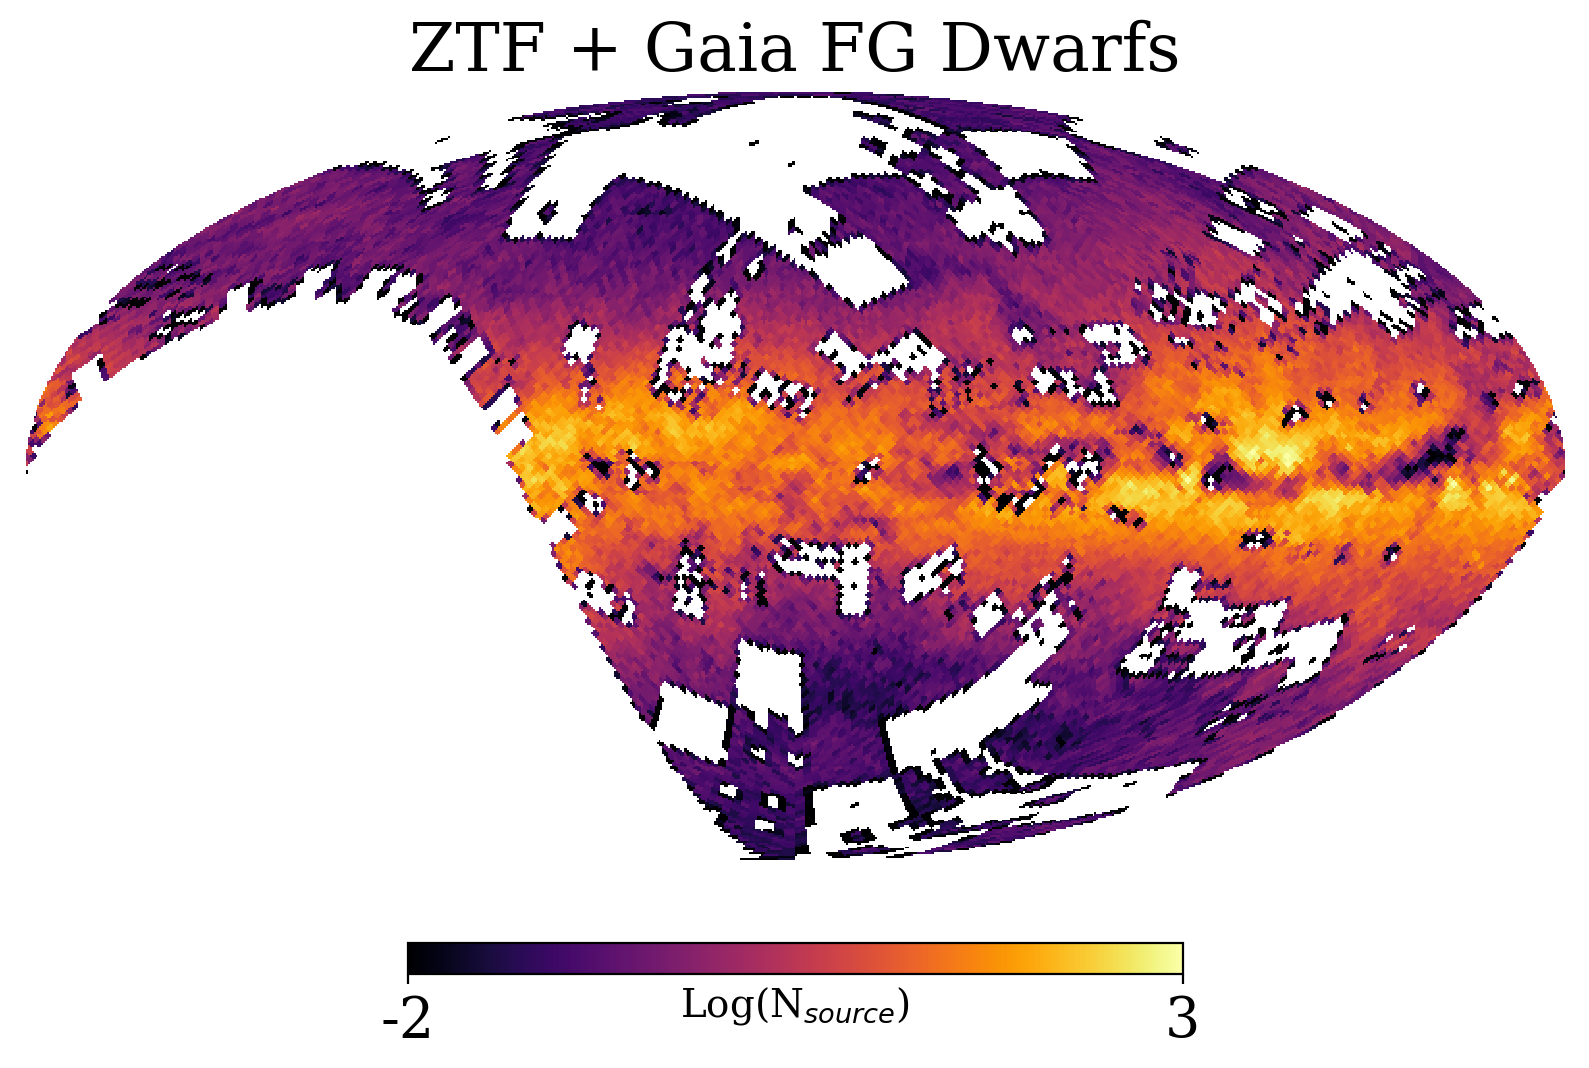

In [131]:
# Create Healpy projection 
hpx_map = cat2hpx(sky_gal.l.value-180,
                  sky_gal.b.value, 
                  nside=50, radec=False)

plt.figure(figsize=(10,10))
plt.grid(True, color='k', lw=22)
hp.mollview(np.log(hpx_map), cmap='inferno', hold=True,min=-2, max=3,
                   flip='astro', remove_dip=False,
                   remove_mono=True, 
                  title='ZTF + Gaia FG Dwarfs', 
           unit='Log(N$_{source}$)')

In [134]:
# hipscat xm_table
table_hips = lsdb.from_dataframe(
    xm_table, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1e10
)

# load lazy
source_tbl_final = table_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
)

In [141]:
pth = '/astro/users/atzanida/datalrg'

In [152]:
type(source_tbl_final)

lsdb.catalog.catalog.Catalog

In [143]:
type(source_tbl_final)

lsdb.catalog.catalog.Catalog

In [ ]:
%%time
# Save it to disk in HiPSCat format
source_tbl_final.to_hipscat(pth, catalog_name='FG_ZTF_gaia.parquet')

Task exception was never retrieved
future: <Task finished name='Task-2191685' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


In [150]:
!ls /astro/users/atzanida/datalrg